# PART 1: Downloading time series of Sentinel-2 images

* **Based on**: [ml4floods notebook](http://trillium.tech/ml4floods/content/ml4ops/HOWTO_inference_on_image_time_series.html) by Gonzalo Mateo-García
* **Adapted for**: [RaVAEn](https://github.com/spaceml-org/RaVAEn/) by Vít Růžička

* **Note**: This notebook doesn't require GPU environment on Colab



This notebook shows how to download Sentinel-2 image time series over an area of interest (AoI) using the Google Earth Engine.

In [ ]:
# Install the ml4floods package
# Specific version!
!pip install -q git+https://github.com/spaceml-org/ml4floods#egg=ml4floods
!pip install -q geemap

In [ ]:
# authenticate in GEE
!earthengine authenticate

In [ ]:
export_to_gcp = False

from google.colab import drive
drive.mount('/content/drive')
bucket_name = None
path_to_export = "/content/drive/My Drive/"

Mounted at /content/drive


In [ ]:
from datetime import datetime, timedelta, timezone
import geopandas as gpd
import pandas as pd
import ee
import geemap.eefolium as geemap
import folium
from ml4floods.data import ee_download
from shapely.geometry import mapping, shape
import matplotlib.pyplot as plt
import os

## Step 1: Config AoI and dates to search for S2 images

<big>**TASK 1: <font color="blue">Find your own location on the planet**</font></big>

Replace the current coordinates in ```center_point```:



In [ ]:
# Location:
center_point = [51.500017134653255, -0.12401778497801658] # London / Big Ben

east_west = 0.02
north_south = 0.02 # each file is approx 5MB with this
east_west = 0.03
north_south = 0.03 # or about 16MB

################################################################# 

p1 = [center_point[1]-east_west, center_point[0]-north_south]
p2 = [center_point[1]-east_west, center_point[0]+north_south]
p3 = [center_point[1]+east_west, center_point[0]+north_south]
p4 = [center_point[1]+east_west, center_point[0]-north_south]

area_of_interest_geojson = {'type': 'Polygon',
   'coordinates': ((p1,p2,p3,p4),)}

area_of_interest = shape(area_of_interest_geojson)

def generate_polygon(bbox):
    """
    Generates a list of coordinates: [[x1,y1],[x2,y2],[x3,y3],[x4,y4],[x1,y1]]
    """
    return [[bbox[0],bbox[1]], [bbox[2],bbox[1]], [bbox[2],bbox[3]], [bbox[0],bbox[3]], [bbox[0],bbox[1]]]

ee.Initialize()

bounds_pol = generate_polygon(area_of_interest.bounds)
pol_2_clip = ee.Geometry.Polygon(bounds_pol)

pol = ee.Geometry(area_of_interest_geojson)

Check if the location is correct - if need be change it and re-run the above fields:

In [ ]:
# Fast preview!
Map = geemap.Map()

Map.addLayer(pol, {"color": 'FF000000'}, "AoI")

Map.centerObject(pol, zoom=12)
folium.LayerControl(collapsed=False).add_to(Map)
Map

## Step 2: Plot cloud coverage of available S2 image over AoI and search dates

Found 146 S2 images between 2021-04-18T00:00:00+00:00 and 2022-04-18T00:00:00+00:00


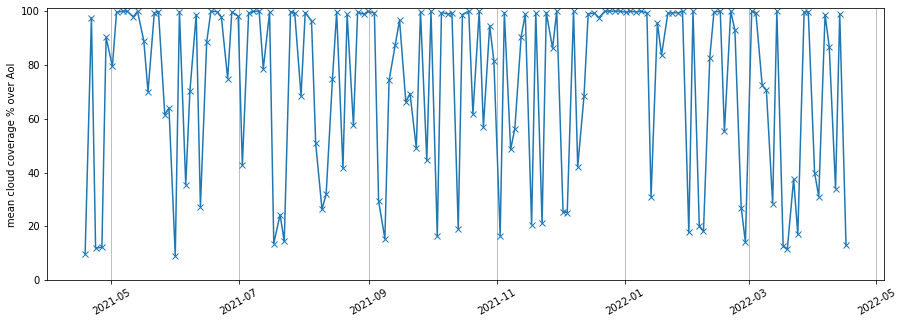

In [ ]:
# Dates
last_date = "2022-04-18"
how_many_days_before = 365

##########

date_end_search = datetime.strptime(last_date,"%Y-%m-%d").replace(tzinfo=timezone.utc)
date_start_search = date_end_search - timedelta(days=how_many_days_before)

# Grab the S2 images and the Permanent water image
img_col = ee_download.get_s2_collection(date_start_search, date_end_search, pol)

# Get info of the S2 images (convert to table)
img_col_info = ee_download.img_collection_to_feature_collection(img_col, 
                                                                ["system:time_start", "valids", "cloud_probability"])

img_col_info_local = gpd.GeoDataFrame.from_features(img_col_info.getInfo())
img_col_info_local["system:time_start"] = img_col_info_local["system:time_start"].apply(lambda x: datetime.utcfromtimestamp(x/1000))

n_images_col = img_col_info_local.shape[0]
print(f"Found {n_images_col} S2 images between {date_start_search.isoformat()} and {date_end_search.isoformat()}")

plt.figure(figsize=(15,5))
plt.plot(img_col_info_local["system:time_start"], img_col_info_local["cloud_probability"],marker="x")
plt.ylim(0,101)
plt.xticks(rotation=30)
plt.ylabel("mean cloud coverage % over AoI")
plt.grid(axis="x")

Filter which ones we will download:

In [ ]:
THRESHOLD_Cloud_Probability_Max = 15 # include this % of cloudy images

selected_idx = []
for i in range(len(img_col_info_local)):
    if img_col_info_local.iloc[i]["cloud_probability"] > THRESHOLD_Cloud_Probability_Max:
        continue
    selected_idx.append(i)

print("Filter selects", len(selected_idx), "dates! (indices", selected_idx,")")

Filter selects 10 dates! (indices [0, 2, 3, 17, 36, 38, 126, 133, 134, 145] )


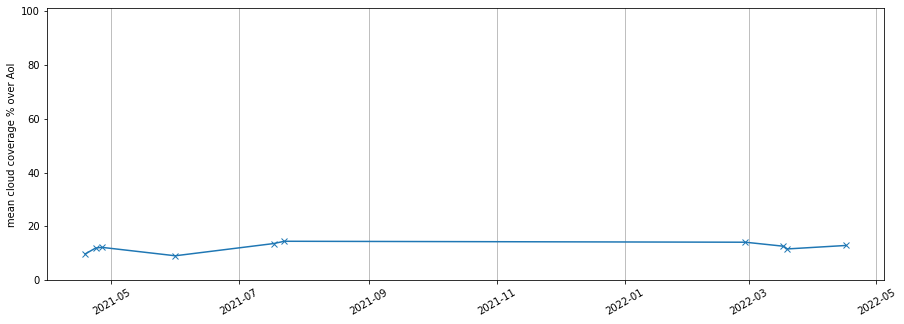

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(img_col_info_local["system:time_start"].iloc[selected_idx], img_col_info_local["cloud_probability"].iloc[selected_idx],marker="x")
plt.ylim(0,101)
plt.xticks(rotation=30)
plt.ylabel("mean cloud coverage % over AoI")
plt.grid(axis="x")

Even after filtering these may be too many (the download could take too long for the sake of this workshop) - let's select random 5 of these:

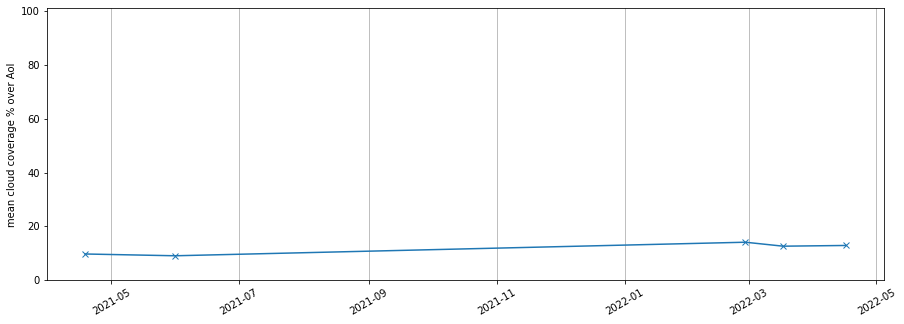

In [ ]:
RANDOM_SUBSET = 5

import random
selected_idx_subset = random.sample(selected_idx, RANDOM_SUBSET)
selected_idx_subset.sort()

plt.figure(figsize=(15,5))
plt.plot(img_col_info_local["system:time_start"].iloc[selected_idx_subset], img_col_info_local["cloud_probability"].iloc[selected_idx_subset],marker="x")
plt.ylim(0,101)
plt.xticks(rotation=30)
plt.ylabel("mean cloud coverage % over AoI")
plt.grid(axis="x")

In [ ]:
# And confirm here:
selected_idx = selected_idx_subset
print(selected_idx)

[0, 17, 126, 133, 145]


In [ ]:
# Second preview with the actual selected images:
# ... takes a while

Map = geemap.Map()

imgs_list = img_col.toList(n_images_col, 0)
for i in range(n_images_col):
    if i not in selected_idx:
        continue
    img_show = ee.Image(imgs_list.get(i))
    
    Map.addLayer(img_show.clip(pol), 
                 {"min":0, "max":3000,
                  "bands":["B4","B3","B2"]}, # "bands":["B11","B8","B4"]} SWIR/NIR/RED
                 f"({i}/{n_images_col}) S2 RGB {img_col_info_local['system:time_start'][i].strftime('%Y-%m-%d')}", 
                 True)
    print("processed id", i)

Map.addLayer(pol, {"color": 'FF000000'}, "AoI")

Map.centerObject(pol, zoom=13)
folium.LayerControl(collapsed=False).add_to(Map)
Map

processed id 0
processed id 17
processed id 126
processed id 133
processed id 145


## Step 4: Download images to run inference

Note that this step may take several minutes (the 5 images we aim at should take about 10 minutes), ideally we let it run during our pause.

In [ ]:
%cd /content

export_task_fun_img = ee_download.export_task_image(
    bucket=bucket_name
)

bands_export = ee_download.BANDS_NAMES["COPERNICUS/S2_HARMONIZED"] + ["probability"]
imgs_list = img_col.toList(n_images_col, 0)

tasks = []
for i in range(n_images_col):
    if i not in selected_idx:
      continue
    
    img_export = ee.Image(imgs_list.get(i))
    img_export = img_export.select(bands_export).toFloat().clip(pol)
    
    date = img_col_info_local['system:time_start'][i].strftime('%Y%m%d')
    
    filename = f"RaVAEn_DEMO_S2_{date}"
    desc=f"location_{date}"
    task = ee_download.mayberun(
                        filename,
                        desc,
                        lambda: img_export,
                        export_task_fun_img,
                        overwrite=False,
                        dry_run=False,
                        bucket_name=bucket_name,
                        verbose=2,
                    )
    if task is not None:
        tasks.append(task)

ee_download.wait_tasks(tasks)

/content
5 tasks running
5 tasks running
5 tasks running
5 tasks running
5 tasks running
5 tasks running
4 tasks running
3 tasks running
3 tasks running
3 tasks running
3 tasks running
3 tasks running
3 tasks running
3 tasks running
3 tasks running
3 tasks running
2 tasks running
1 tasks running
1 tasks running
1 tasks running
1 tasks running
1 tasks running
1 tasks running
1 tasks running
Tasks failed: 0


In [ ]:
# wait +- 10-15 mins! (for 5 images)
# warning, if you download many files (like 22) it may take significantly more time, as the download service probably gets flooded...

## Step 5: Check downloaded files

In [ ]:
from glob import glob
exported_files = glob(f"{path_to_export}RaVAEn_DEMO_S2_*.tif")

exported_files

['/content/drive/My Drive/RaVAEn_DEMO_S2_20210531.tif',
 '/content/drive/My Drive/RaVAEn_DEMO_S2_20210418.tif',
 '/content/drive/My Drive/RaVAEn_DEMO_S2_20220227.tif',
 '/content/drive/My Drive/RaVAEn_DEMO_S2_20220317.tif',
 '/content/drive/My Drive/RaVAEn_DEMO_S2_20220416.tif']

In [ ]:
!ls /content/drive/MyDrive/RaVAEn_DEMO_* -luah

-rw------- 1 root root 17M Jan  1  1970 /content/drive/MyDrive/RaVAEn_DEMO_S2_20210418.tif
-rw------- 1 root root 17M Jan  1  1970 /content/drive/MyDrive/RaVAEn_DEMO_S2_20210531.tif
-rw------- 1 root root 17M Jan  1  1970 /content/drive/MyDrive/RaVAEn_DEMO_S2_20220227.tif
-rw------- 1 root root 17M Jan  1  1970 /content/drive/MyDrive/RaVAEn_DEMO_S2_20220317.tif
-rw------- 1 root root 17M Jan  1  1970 /content/drive/MyDrive/RaVAEn_DEMO_S2_20220416.tif


In [ ]:
""" BACKUP - IF SOMETHING WENT WRONG, JUST DOWNLOAD THESE:

!pip install --quiet --upgrade gdown

%cd /content/

# From https://drive.google.com/file/d/1iEXMQUfcc0_qwDrXu91NSBwzXpTyPe1u/view?usp=sharing
!gdown https://drive.google.com/uc?id=1iEXMQUfcc0_qwDrXu91NSBwzXpTyPe1u -O downloaded_ex4.zip
!unzip -q downloaded_ex4.zip
!rm downloaded_ex4.zip
"""
pass

# PART 2: Visualize downloaded Sentinel-2 images

* **Prerequisite**: Download the images using PART 1
* **Note**: This notebook doesn't require GPU environment on Colab
* **Learning outcomes**: Understanding different bands, using some of the established summative indices 


This notebook explores how the downloaded remote sensing images differ from typical RGB photos data.

In [ ]:
!pip -q install rasterio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!ls /content/drive/MyDrive/RaVAEn_DEMO_S2_*.tif -luah

-rw------- 1 root root 17M Jan  1  1970 /content/drive/MyDrive/RaVAEn_DEMO_S2_20210418.tif
-rw------- 1 root root 17M Jan  1  1970 /content/drive/MyDrive/RaVAEn_DEMO_S2_20210531.tif
-rw------- 1 root root 17M Jan  1  1970 /content/drive/MyDrive/RaVAEn_DEMO_S2_20220227.tif
-rw------- 1 root root 17M Jan  1  1970 /content/drive/MyDrive/RaVAEn_DEMO_S2_20220317.tif
-rw------- 1 root root 17M Jan  1  1970 /content/drive/MyDrive/RaVAEn_DEMO_S2_20220416.tif


Let's copy the data to our local folder:

In [ ]:
!cp /content/drive/MyDrive/RaVAEn_DEMO_S2_*.tif .

In [ ]:
from glob import glob
s2_files = glob("./RaVAEn_DEMO_S2_*.tif")
s2_files.sort()
s2_files

['./RaVAEn_DEMO_S2_20210418.tif',
 './RaVAEn_DEMO_S2_20210531.tif',
 './RaVAEn_DEMO_S2_20220227.tif',
 './RaVAEn_DEMO_S2_20220317.tif',
 './RaVAEn_DEMO_S2_20220416.tif']

In [ ]:
# If need be select a smaller subset:
# s2_files = s2_files[0:5]
# s2_files

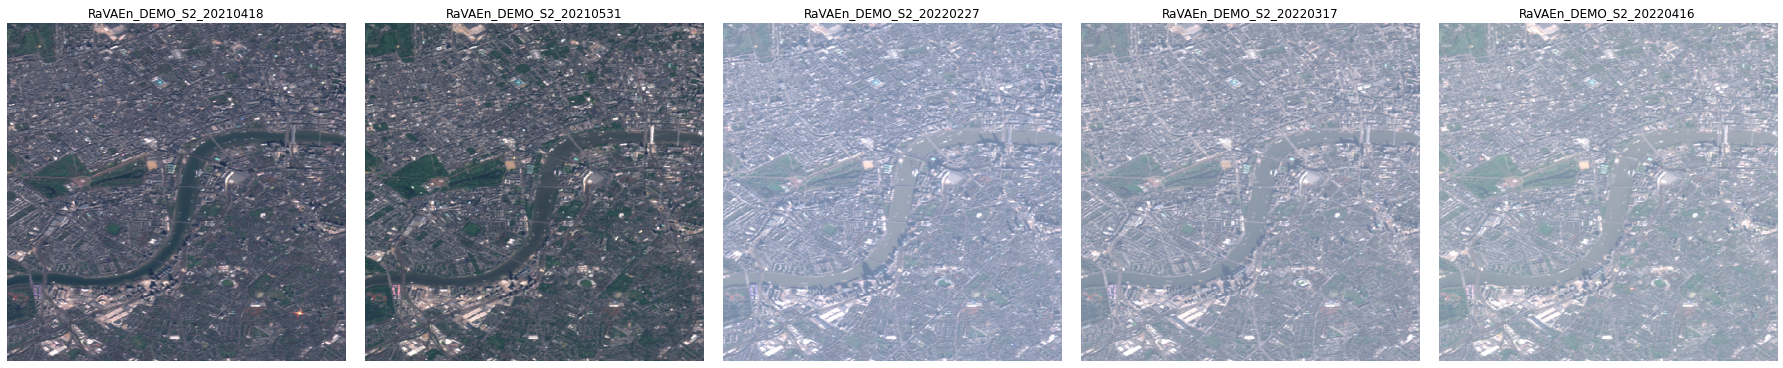

In [ ]:
import rasterio.plot as rstplt
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from tqdm import tqdm
import os

size_read = 600

with rasterio.open(s2_files[0]) as src:
    width = src.width
    height = src.height

    # Compute shape to read to from pyramids and speed up plotting
    shape = src.shape
    if (size_read >= shape[0]) and (size_read >= shape[1]):
      out_shape = shape
    elif shape[0] > shape[1]:
      out_shape = (size_read, int(round(shape[1]/shape[0] * size_read)))
    else:
      out_shape = (int(round(shape[0] / shape[1] * size_read)), size_read)

n_plots = len(s2_files)
  
fig, ax = plt.subplots(1, n_plots, figsize=(n_plots*5*width/height,5), tight_layout=True)

# Plot S2 files
for i, s2_file in enumerate(s2_files):
  with rasterio.open(s2_file) as src:
    img = src.read([4,3,2], out_shape=out_shape)

    # from skimage.transform import resize
    # img = resize(img, (img.shape[0], int(width), int(height*0.8)))

  name = s2_file.split("RaVAEn_DEMO_S2_")[-1]

  img = np.clip(img/3000., 0, 1)
  rstplt.show(img, ax=ax[i])
  date = os.path.basename(s2_file)[:-4]
  ax[i].set_title(date)
  ax[i].axis("off")

plt.show()

### bonus: prettier visualization

In [ ]:
import imageio, rasterio
import time
import PIL
from PIL import Image, ImageFont, ImageDraw
from glob import glob
import numpy as np

!wget https://github.com/previtus/AttentionPipeline/raw/70e37142e79996e62c51c85de996127e38606efa/video_parser_v1/font/FiraMono-Medium.otf
font = ImageFont.truetype("FiraMono-Medium.otf", 30)

def load_rgb(paths):
  images = []
  n_plots = len(s2_files)
  
  for i, s2_file in enumerate(paths):
    with rasterio.open(s2_file) as src:
      img = src.read([4,3,2])
      # from skimage.transform import resize
      # img = resize(img, (img.shape[0], int(width), int(height*0.8)))
      images.append(img)
  return images

def draw_text(image, text):
  PIL_image = PIL.Image.fromarray((255*image).astype('uint8'), 'RGB')
  draw = PIL.ImageDraw.Draw(PIL_image)
  color_text = (255,255,255,255)
  color_border = (0,0,0,255)
  color_textbox = (40,40,40,255)

  # text:
  left = 15
  top = 15
  label_size = list(draw.textsize(text, font))
  offset = [3,3]
  t_offset = [0,-2]
  text_origin = np.array([left, top])
  draw.rectangle([tuple(text_origin - offset), tuple(text_origin + label_size + offset)], fill=color_textbox)
  draw.text(tuple(text_origin+t_offset), text, fill=color_text, font=font)

  # whole image border:
  bbox = list(PIL_image.getbbox())
  bbox[3] = bbox[3] - 1 # bottom should also get 1 px border
  draw.rectangle(bbox, None, color_border)
  
  return PIL_image

def save_as_row(images_array, names, target_path):
  n_repeats = len(images_array)
  ch,h,w = images_array[0].shape

  final_shape = (h, w*n_repeats, ch)
  assembly_image = np.zeros(final_shape)
  print(assembly_image.shape)

  for i, img in enumerate(images_array):
    img = np.moveaxis(img, 0, -1)
    img = np.clip(img/3000., 0, 1)
    # print(img.shape)

    img = draw_text(img, names[i])
    assembly_image[:, i*w:(i+1)*w, :] = img

  imageio.imwrite(target_path, (assembly_image).astype(np.uint8))

def plot_from_glob(glob_str, save_name, subset = None):
  s2_files = glob(glob_str)
  s2_files.sort()

  images = load_rgb(s2_files)
  names = [path.split("_")[-1].split(".tif")[0] for path in s2_files]
  names = [time.strftime("%d/%m/%Y",time.strptime(n,"%Y%m%d")) for n in names]
  # names = [path.split("/")[-1].split(".tif")[0] for path in s2_files] # alternate name format
  # names = [n.replace("-","/") for n in names]
  if subset is not None:
    images = images[0:subset]
    names = names[0:subset]
  save_as_row(images, names, save_name)

(669, 3345, 3)


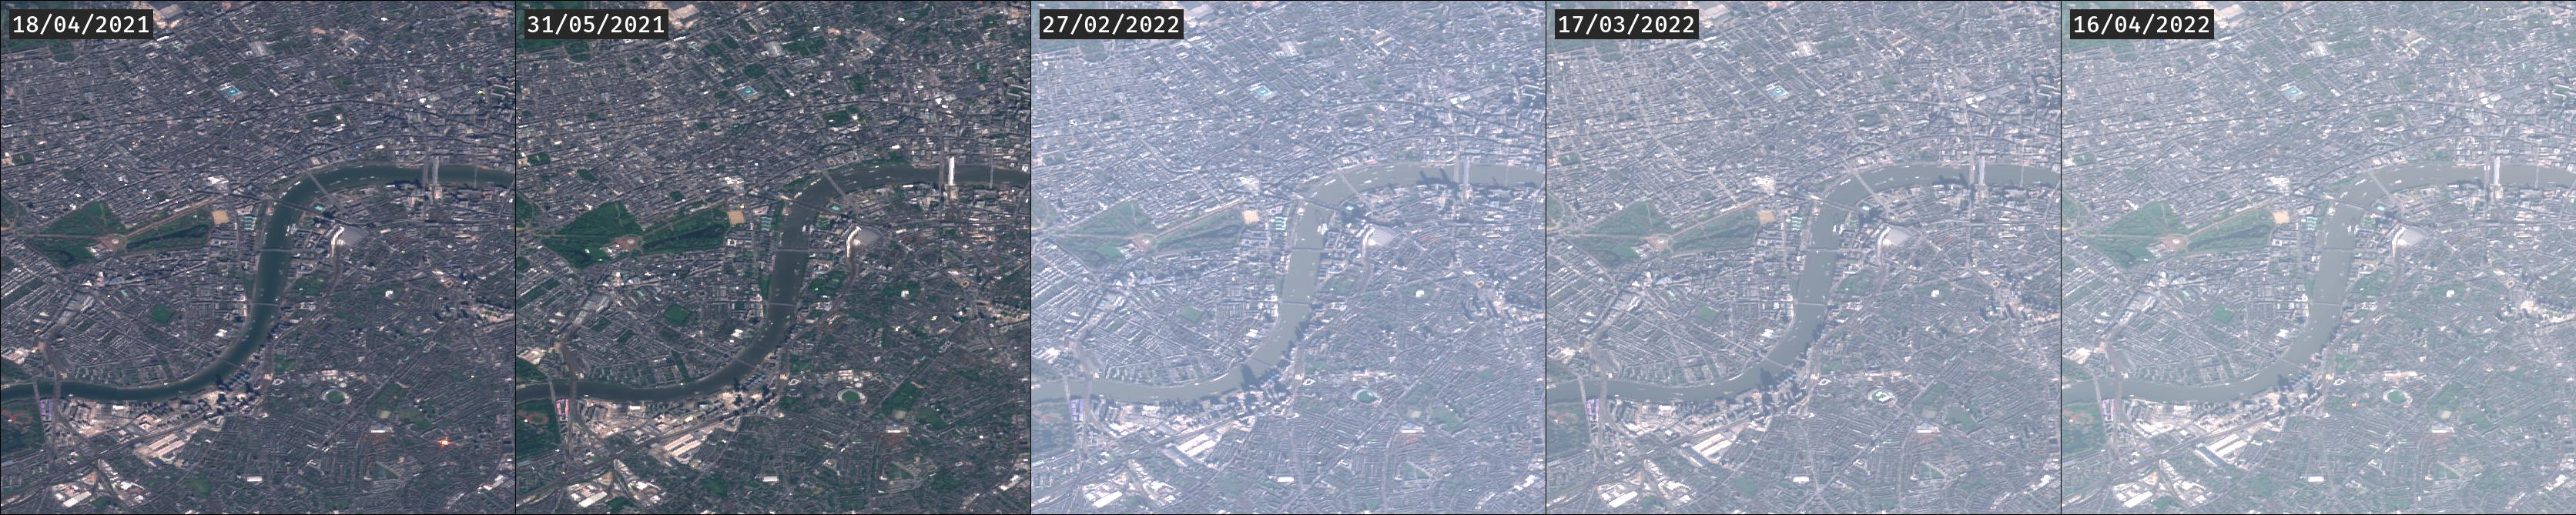

In [ ]:
plot_from_glob("./RaVAEn_DEMO_S2_*.tif", "pretty_plot.jpg", subset = 5)
# Now look at the saved file: "pretty_plot.jpg"

from IPython.display import Image
Image(open('pretty_plot.jpg','rb').read())

## Exploring bands

In [ ]:
s2_file = s2_files[0] # select one

with rasterio.open(s2_file) as src:
  img = src.read()
  # from skimage.transform import resize
  # img = resize(img, (img.shape[0], int(width), int(height*0.8)))

print(img.shape)

(15, 669, 669)


We see that this is not an ordinary image file ... for one it has way to many bands! (Regular image would have three - "RGB" - the red, blue and green channels.)

If we check https://en.wikipedia.org/wiki/Sentinel-2, we will see that this is what we usually mean by having "multi-spectral" data. Still three of these bands are actually the RGB channels, so we could have used these to show how the image would look to a human eye.

In [ ]:
BANDS_S2 = ["B1 – Coastal aerosol",
  "B2 – Blue",
  "B3 – Green",
  "B4 – Red",
  "B5 – Vegetation red edge",
  "B6 – Vegetation red edge",
  "B7 – Vegetation red edge",
  "B8 – NIR",
  "B8A – Narrow NIR",
  "B9 – Water vapour",
  "B10 – SWIR – Cirrus",
  "B11 – SWIR",
  "B12 – SWIR",
  "QA60 – cloud mask information"]

# More information about the bands -> https://en.wikipedia.org/wiki/Sentinel-2

In addition, there is a plenty of other information present in the GeoTIFF file (more in the example from [rasterio documentation](https://rasterio.readthedocs.io/en/latest/quickstart.html)).

In [ ]:
# We can also reconstruct the location the image is representing
# -> This is not your regular RGB tif image, it has extra information stored about the GeoLocation!
print(src.bounds)

BoundingBox(left=-0.15406107122649793, bottom=51.46996235044051, right=-0.09396377871890194, top=51.53005964294811)


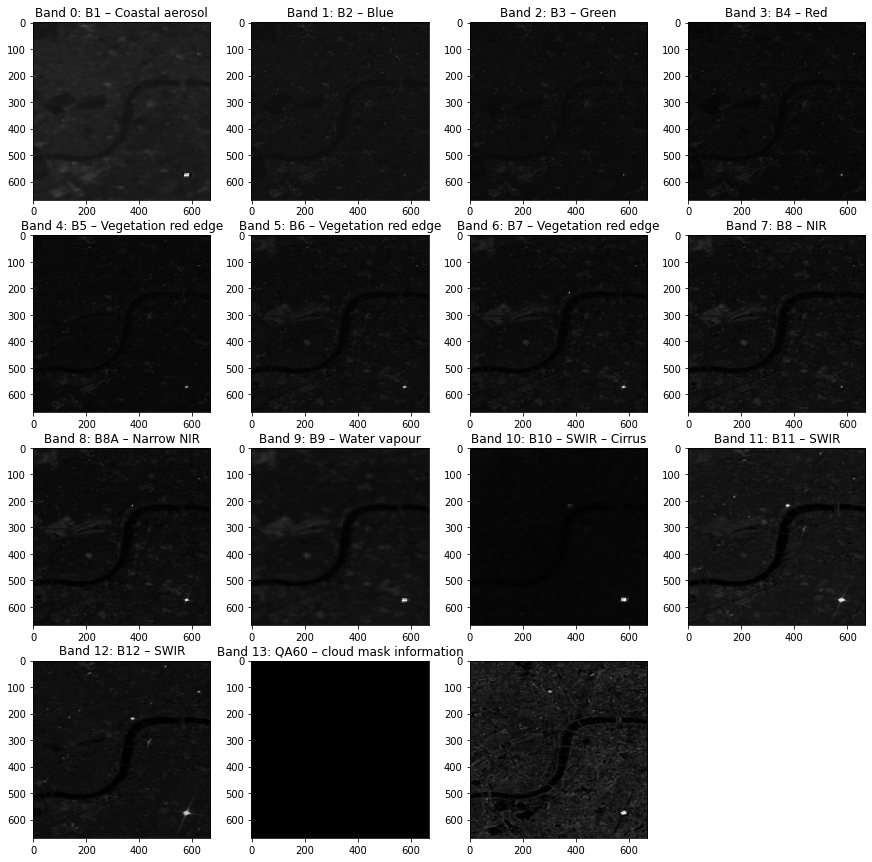

In [ ]:
import rasterio.plot as rstplt
import matplotlib.pyplot as plt
import math

def show_all_bands(data):
  bands = data.shape[0] # for example 15  
  n = math.ceil(math.sqrt(bands))
  m = math.ceil(bands / n)

  f, axes = plt.subplots(n, m, figsize=(15,15))
  for band_i in range(bands):
    ax = axes.flatten()[band_i]
    # data = np.clip(data/3000., 0, 1) # < simple visualization trick
    ax.imshow(data[band_i,:,:], cmap=plt.get_cmap('gray'))

    if band_i < 14:
      ax.title.set_text('Band '+str(band_i)+': '+str(BANDS_S2[band_i]))
  for band_i in range(band_i+1,m*n):
    ax = axes.flatten()[band_i]
    ax.set_visible(False)

  plt.show()

show_all_bands(img)

Now, why are some of these bands so dark and hard to see?

Shape: (669, 669)


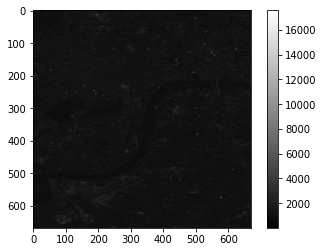

In [ ]:
def show_img(data, colorbar=True, figsize=None, cmap=None):
  # data = np.clip(data/3000., 0, 1)
  if figsize is not None:
    plt.figure(figsize=figsize)
  if cmap is None:
    plt.imshow(data, cmap=plt.get_cmap('gray'))
  else:
    plt.imshow(data, cmap=plt.get_cmap(cmap))

  if colorbar: plt.colorbar()
  plt.show()

blue_channel = img[1]
print("Shape:", blue_channel.shape)
show_img(blue_channel)

Looking at the histogram, we can see that there are some (probably errorneous) pixels which have super large values.

The visualization by default considers all of these values and scales the image between black to white acording to the minimal and the maximal value in this image ...

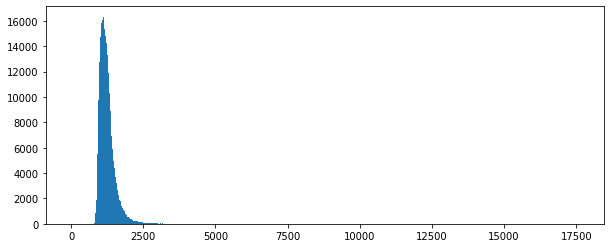

In [ ]:
plt.figure(figsize=(10,4))
plt.hist(blue_channel.flatten(), bins=1000)
plt.show()

In [ ]:
# We should cut the data to fit a better range - for example keeping only values between 0 and 3000.
# We can check the typical values here: https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l1c/

"""
Optical bands	Digital numbers (unitless)	DN	UINT15	0 - 4000*
*Higher values are expected in infrared bands. Reflectance values can easily be above 1.
"""
pass

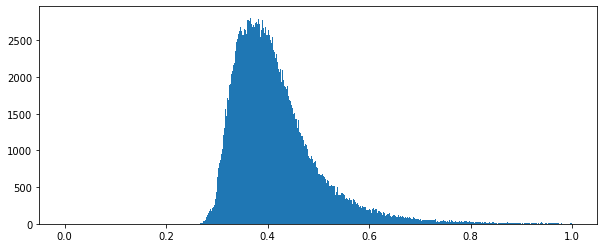

In [ ]:
plt.figure(figsize=(10,4))

# For example like this:
# clipped_data = np.clip(blue_channel, 0, 3000)
clipped_data = np.clip(blue_channel/3000., 0, 1)

plt.hist(clipped_data.flatten(), bins=1000)
plt.show()

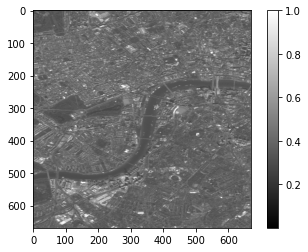

In [ ]:
show_img(clipped_data)

In [ ]:
# Alternatively print out statistics one by one
bands = img.shape[0]
for band_i in range(bands):
  data_array = img[band_i,:,:].flatten()
  if band_i < 14:
    band_name = BANDS_S2[band_i]
  else:
    band_name = "extra band"
  print('Band '+str(band_i)+': '+str(band_name), "\n\tmin:", np.min(data_array), "\tmax:", np.max(data_array), "\tavg:", np.mean(data_array), "\tstd:", np.std(data_array))

Band 0: B1 – Coastal aerosol 
	min: 740.0 	max: 7165.0 	avg: 1521.705 	std: 174.66493
Band 1: B2 – Blue 
	min: 1.0 	max: 17572.0 	avg: 1252.5038 	std: 294.46387
Band 2: B3 – Green 
	min: 1.0 	max: 20497.0 	avg: 1079.3933 	std: 327.8094
Band 3: B4 – Red 
	min: 1.0 	max: 23186.0 	avg: 1026.5668 	std: 420.45905
Band 4: B5 – Vegetation red edge 
	min: 200.0 	max: 23357.0 	avg: 1159.1979 	std: 369.0192
Band 5: B6 – Vegetation red edge 
	min: 1.0 	max: 25822.0 	avg: 1395.1779 	std: 541.60657
Band 6: B7 – Vegetation red edge 
	min: 1.0 	max: 28000.0 	avg: 1491.3507 	std: 652.58185
Band 7: B8 – NIR 
	min: 1.0 	max: 24058.0 	avg: 1449.1875 	std: 663.7155
Band 8: B8A – Narrow NIR 
	min: 1.0 	max: 28000.0 	avg: 1545.8275 	std: 736.34247
Band 9: B9 – Water vapour 
	min: 1.0 	max: 11421.0 	avg: 773.37054 	std: 317.00607
Band 10: B10 – SWIR – Cirrus 
	min: 6.0 	max: 383.0 	avg: 16.242271 	std: 7.8117723
Band 11: B11 – SWIR 
	min: 1.0 	max: 16750.0 	avg: 1382.1588 	std: 585.7471
Band 12: B12 – SWIR 


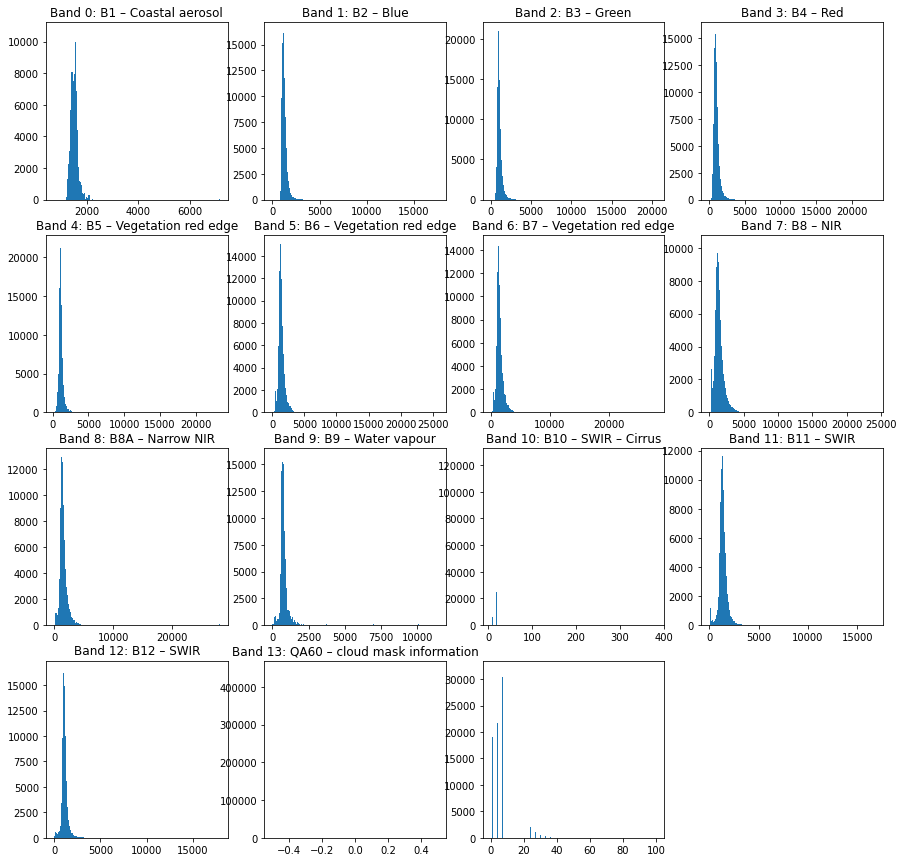

In [ ]:
import rasterio.plot as rstplt
import matplotlib.pyplot as plt
import math

def show_all_histograms(data):
  bands = data.shape[0] # for example 15  
  n = math.ceil(math.sqrt(bands))
  m = math.ceil(bands / n)

  f, axes = plt.subplots(n, m, figsize=(15,15))
  for band_i in range(bands):
    ax = axes.flatten()[band_i]
    # data = np.clip(data/3000., 0, 1) # < simple visualization trick
    ax.hist(data[band_i,:,:].flatten(), bins=1000)

    if band_i < 14:
      ax.title.set_text('Band '+str(band_i)+': '+str(BANDS_S2[band_i]))
  for band_i in range(band_i+1,m*n):
    ax = axes.flatten()[band_i]
    ax.set_visible(False)

  plt.show()

show_all_histograms(img)

### Bands normalization with logarithm and rescaling

When working with neural networks we would typically expect well behaving data inputs (this means their range should be nearby 0 and not too large, yet there is enough distinction between the different values). For such a large dynamic range as we saw in these examples, we used logarithm followed with a rescaling by manually found parameters.

In [ ]:
#@title init these manually found scaling parameters

BANDS_S2_BRIEF = ["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B10","B11","B12"]
RESCALE_PARAMS = {
    "B1" : {  "x0": 7.3,
              "x1": 7.6,
              "y0": -1,
              "y1": 1,
    },
    "B2" : {  "x0": 6.9,
              "x1": 7.5,
              "y0": -1,
              "y1": 1,
    },
    "B3" : {  "x0": 6.5,
              "x1": 7.4,
              "y0": -1,
              "y1": 1,
    },
    "B4" : {  "x0": 6.2,
              "x1": 7.5,
              "y0": -1,
              "y1": 1,
    },
    "B5" : {  "x0": 6.1,
              "x1": 7.5,
              "y0": -1,
              "y1": 1,
    },
    "B6" : {  "x0": 6.5,
              "x1": 8,
              "y0": -1,
              "y1": 1,
    },
    "B7" : {  "x0": 6.5,
              "x1": 8,
              "y0": -1,
              "y1": 1,
    },
    "B8" : {  "x0": 6.5,
              "x1": 8,
              "y0": -1,
              "y1": 1,
    },
    "B8A" : { "x0": 6.5,
              "x1": 8,
              "y0": -1,
              "y1": 1,
    },
    "B9" : {  "x0": 6,
              "x1": 7,
              "y0": -1,
              "y1": 1,
    },
    "B10" : { "x0": 2.5,
              "x1": 4.5,
              "y0": -1,
              "y1": 1,
    },
    "B11" : { "x0": 6,
              "x1": 8,
              "y0": -1,
              "y1": 1,
    },
    "B12" : { "x0": 6,
              "x1": 8,
              "y0": -1,
              "y1": 1,
    }
}

In [ ]:
import rasterio.plot as rstplt
import matplotlib.pyplot as plt
import math

def show_all_bands(data, images_or_hist = "images"):
  bands = data.shape[0] # for example 15  
  n = math.ceil(math.sqrt(bands))
  m = math.ceil(bands / n)

  f, axes = plt.subplots(n, m, figsize=(15,15))
  for band_i in range(bands):
    ax = axes.flatten()[band_i]
    
    data_one_band = data[band_i,:,:]
    if band_i < len(BANDS_S2_BRIEF):
      # log
      data_one_band = np.log(data_one_band)
      data_one_band[np.isinf(data_one_band)] = np.nan

      # rescale
      r = RESCALE_PARAMS[BANDS_S2_BRIEF[band_i]]
      x0,x1,y0,y1 = r["x0"], r["x1"], r["y0"], r["y1"] 
      data_one_band = ((data_one_band - x0) / (x1 - x0)) * (y1 - y0) + y0

    if images_or_hist == "images":
      ax.imshow(data_one_band, cmap=plt.get_cmap('gray'))
    else:
      ax.hist(data_one_band.flatten(), bins=1000)

    if band_i < 14:
      ax.title.set_text('Band '+str(band_i)+': '+str(BANDS_S2[band_i]))
  for band_i in range(band_i+1,m*n):
    ax = axes.flatten()[band_i]
    ax.set_visible(False)

  plt.show()

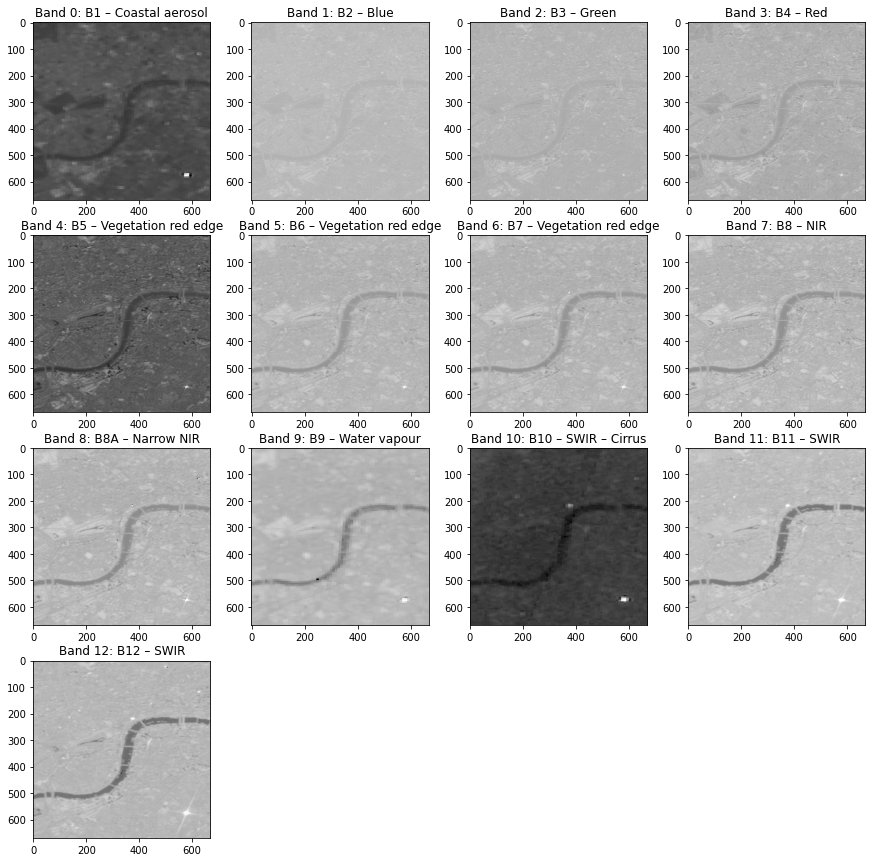

In [ ]:
show_all_bands(img[0:13])

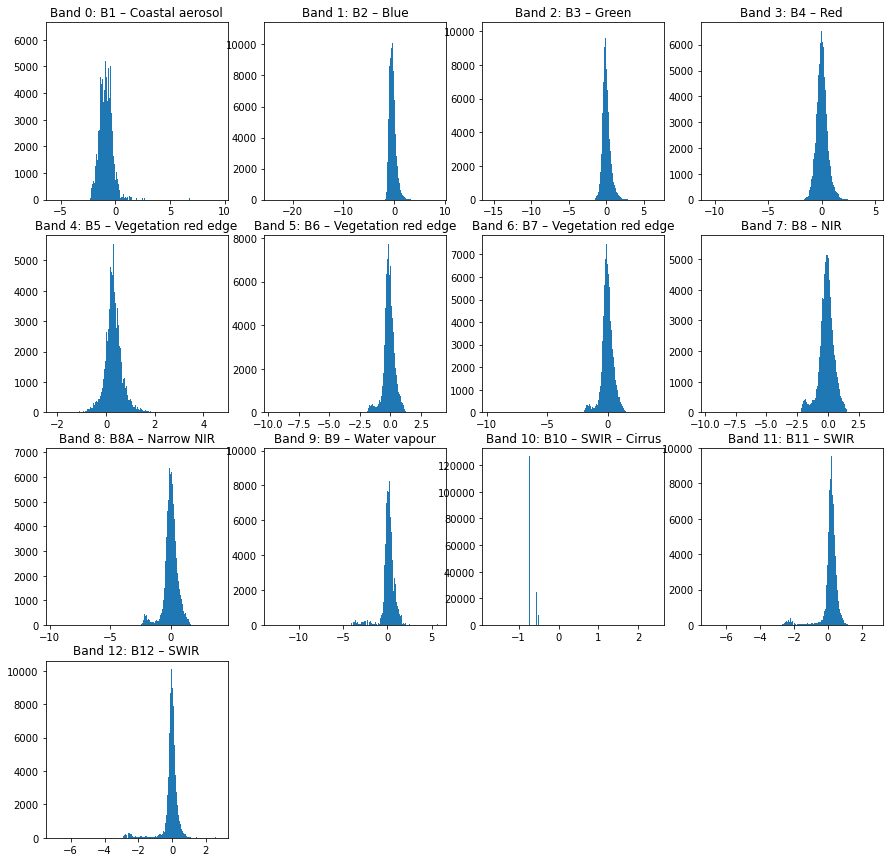

In [ ]:
show_all_bands(img[0:13],"hist")

Great, now these are mostly nicely zero-centered (the peak you can see on the histograms will be roughly around 0).

## Using some useful indices

### Example 1: vegetation surfaces

Check our [this page](https://gisgeography.com/ndvi-normalized-difference-vegetation-index/) for more details on the "NDVI" (Normalized difference vegetation index) indicator we will be using.

> The NDVI is a dimensionless index that describes the difference between visible and near-infrared reflectance of vegetation cover and can be used to estimate the density of green on an area of land (Weier and Herring, 2000)

<img src="https://gisgeography.com/wp-content/uploads/2017/08/ndvi-example.jpg">

In [ ]:
# Normalized Difference Vegetation Index
# Source: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndvi/#
def calculate_ndvi(red, nir):
    ndvi = ((nir - red)/(nir + red))
    # ndvi = (B08 - B04) / (B08 + B04);
    return ndvi

red = img[3] # B4 (remember we count from 0 in python)
nir = img[7] # B8

ndvi = calculate_ndvi(red, nir)

This shows the image in grayscale with values between -1 to +1. 

> NDVI values range from +1.0 to -1.0. Areas of barren rock, sand, or snow usually show very low NDVI values (for example, 0.1 or less). Sparse vegetation such as shrubs and grasslands or senescing crops may result in moderate NDVI values (approximately 0.2 to 0.5).



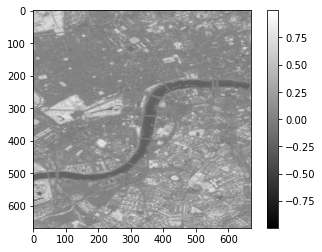

In [ ]:
show_img(ndvi)

In [ ]:
# We can also the special color map from EO Browser

def ndvi_pix2color(ndvi):
  # Visualization, as used in EO Browser:
  # source https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndvi/
  # ndvi pixel value to rgb colour
  if (ndvi<-1.1): return [0,0,0]
  elif (ndvi<-0.2): return [0.75,0.75,0.75]
  elif (ndvi<-0.1): return [0.86,0.86,0.86]
  elif (ndvi<0): return [1,1,0.88]
  elif (ndvi<0.025): return [1,0.98,0.8]
  elif (ndvi<0.05): return [0.93,0.91,0.71]
  elif (ndvi<0.075): return [0.87,0.85,0.61]
  elif (ndvi<0.1): return [0.8,0.78,0.51]
  elif (ndvi<0.125): return [0.74,0.72,0.42]
  elif (ndvi<0.15): return [0.69,0.76,0.38]
  elif (ndvi<0.175): return [0.64,0.8,0.35]
  elif (ndvi<0.2): return [0.57,0.75,0.32]
  elif (ndvi<0.25): return [0.5,0.7,0.28]
  elif (ndvi<0.3): return [0.44,0.64,0.25]
  elif (ndvi<0.35): return [0.38,0.59,0.21]
  elif (ndvi<0.4): return [0.31,0.54,0.18]
  elif (ndvi<0.45): return [0.25,0.49,0.14]
  elif (ndvi<0.5): return [0.19,0.43,0.11]
  elif (ndvi<0.55): return [0.13,0.38,0.07]
  elif (ndvi<0.6): return [0.06,0.33,0.04]
  else: return [0,0.27,0]

In [ ]:
# We just map the 0-1 ndvi value to a colour
mapped_ndvi = [[ndvi_pix2color(pixel) for pixel in row] for row in ndvi]
mapped_ndvi = np.asarray(mapped_ndvi)
print(ndvi.shape, "was mapped to", mapped_ndvi.shape)

(669, 669) was mapped to (669, 669, 3)


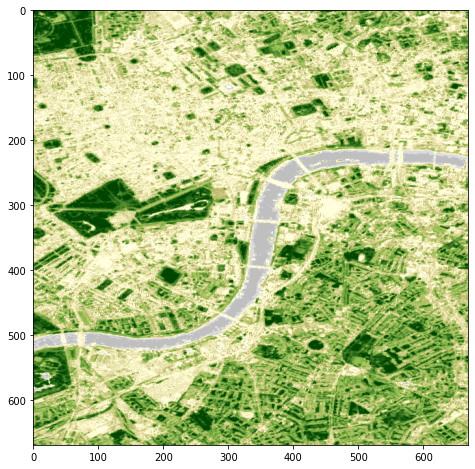

In [ ]:
show_img(mapped_ndvi, False, figsize=(8,8))

In [ ]:
# Let's prepare this fast function for later...
def img2_ndvi_viz(img, return_visualization=True):
  ndvi = calculate_ndvi(img[3], img[7])
  if return_visualization:
    return np.asarray([[ndvi_pix2color(pixel) for pixel in row] for row in ndvi])
  else:
    return ndvi

### Example 2: water bodies surfaces

In [ ]:
# Normalized Difference Water Index
def calculate_ndwi(green, nir):
    ndwi = ((green - nir)/(green + nir))
    # Sentinel-2 NDWI = (B03 - B08) / (B03 + B08)
    return ndwi

green = img[2] # B3 (remember we count from 0 in python)
nir = img[7] # B8

ndwi = calculate_ndwi(green, nir)

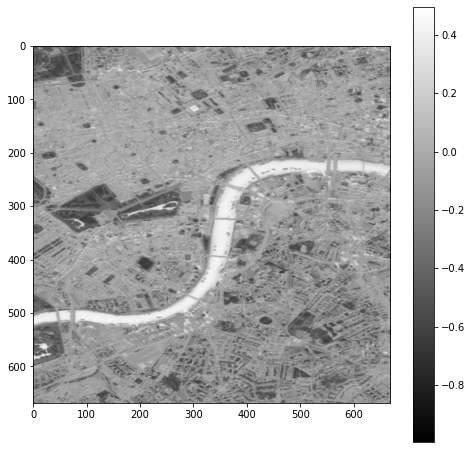

In [ ]:
show_img(ndwi, figsize=(8,8))

"Values description: Water features should have positive values, while soil and terrestrial vegetation features have zero or negative values."

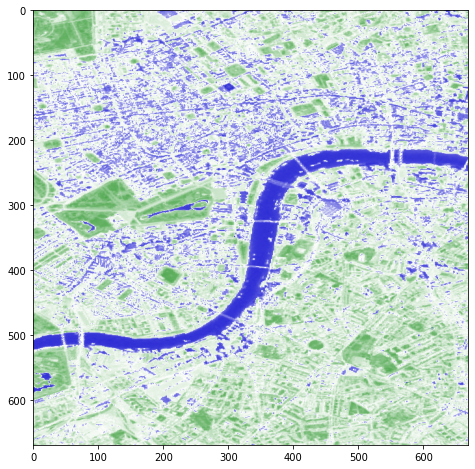

In [ ]:
# Visualization script adapted from https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndwi/#
# Basic definition "S. K. McFEETERS (1996) The use of the Normalized Difference Water Index (NDWI) in the delineation of open water features"
#  but what this is using is edited to also show vegetation.
from PIL import ImageColor
import colorsys
colorRamp1 = np.asarray(ImageColor.getcolor("#FFFFFF", "RGB"))/255., np.asarray(ImageColor.getcolor("#008000", "RGB"))/255.
colorRamp2 = np.asarray(ImageColor.getcolor("#FFFFFF", "RGB"))/255., np.asarray(ImageColor.getcolor("#0000CC", "RGB"))/255.

def lerp_rgb(a,b,t):
    return [a[0] + (b[0] - a[0]) * t,
            a[1] + (b[1] - a[1]) * t,
            a[2] + (b[2] - a[2]) * t]

def interpolate_color(value, colorRamp):
  return lerp_rgb(colorRamp[0],colorRamp[1],value)

import math
def ndwi_pix2color(ndwi):
    if ndwi < 0:
        val = -ndwi
        assert val >= 0 and val <= 1
        return interpolate_color(val,colorRamp1)
    else:
        val = math.sqrt(math.sqrt(ndwi))
        assert val >= 0 and val <= 1
        return interpolate_color(val,colorRamp2)

# We just map the 0-1 ndvi value to a colour
mapped_ndwi = [[ndwi_pix2color(pixel) for pixel in row] for row in ndwi]
mapped_ndwi = np.asarray(mapped_ndwi)
show_img(mapped_ndwi, False, figsize=(8,8))

In [ ]:
# Let's prepare this fast function for later...
def img2_ndwi_viz(img, return_visualization=True):
  ndwi = calculate_ndwi(img[2], img[7])
  if return_visualization:
    return np.asarray([[ndwi_pix2color(pixel) for pixel in row] for row in ndwi])
  else:
    return ndwi

More indices available for example at: https://spaceforum.sk/en/space-data-analysis-course/semester-projects/visualization-of-normalized-satellite-indexes-using-sentinel-2-data/

## What about time? And animations?

Can we look at how these indices change over time?

In [ ]:
# If we just wanted the RGB visualization
def img2_rgb_viz(img):
  print(img.shape)
  img = img[[3,2,1],:,:]
  img = np.clip(img/3000., 0, 1)

  return np.moveaxis(img, 0, -1)

In [ ]:
# Choose and uncomment one:

visualize_function = img2_ndvi_viz
# visualize_function = img2_ndwi_viz
# visualize_function = img2_rgb_viz

In [ ]:
save_as_frames = True
folder = "visualizations"
!mkdir $folder

NDVI can be used to track growth of plants.

Finished with 20210418.tif
Finished with 20210531.tif
Finished with 20220227.tif
Finished with 20220317.tif
Finished with 20220416.tif


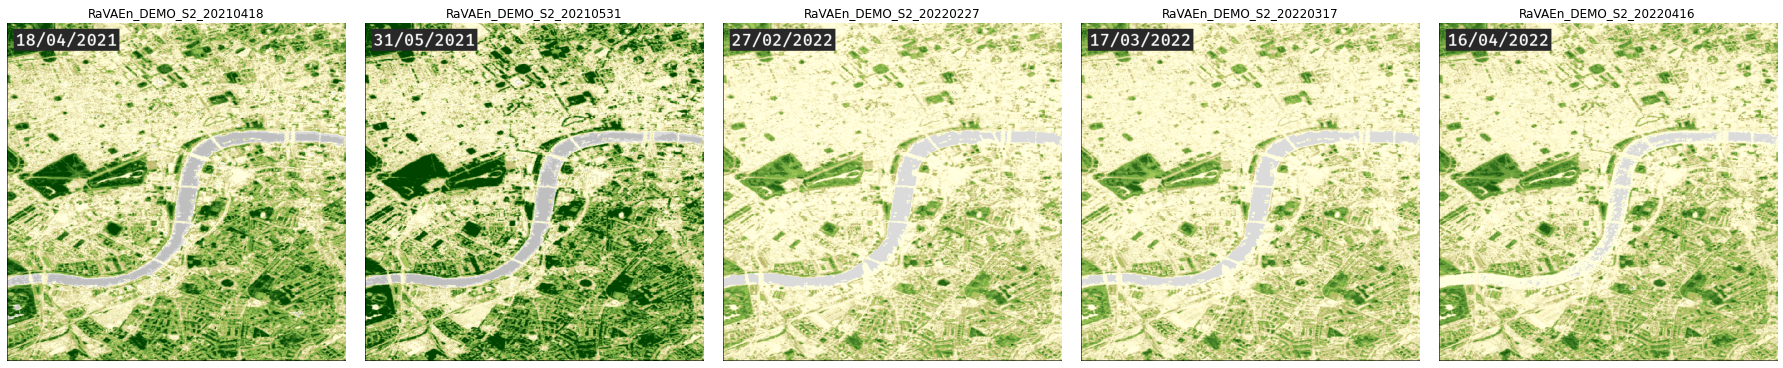

In [ ]:
import imageio

size_read = 600
with rasterio.open(s2_files[0]) as src:
    width = src.width
    height = src.height

    # Compute shape to read to from pyramids and speed up plotting
    shape = src.shape
    if (size_read >= shape[0]) and (size_read >= shape[1]):
      out_shape = shape
    elif shape[0] > shape[1]:
      out_shape = (size_read, int(round(shape[1]/shape[0] * size_read)))
    else:
      out_shape = (int(round(shape[0] / shape[1] * size_read)), size_read)

n_plots = len(s2_files)
fig, ax = plt.subplots(1, n_plots, figsize=(n_plots*5*width/height,5), tight_layout=True)
  
# Plot S2 files
for i, s2_file in enumerate(s2_files):
  with rasterio.open(s2_file) as src:
    img = src.read(out_shape=out_shape)
    # from skimage.transform import resize
    # img = resize(img, (img.shape[0], int(width), int(height*0.8)))

  name = s2_file.split("RaVAEn_DEMO_S2_")[-1]
  visualization = visualize_function(img)

  # Write in date as the text:
  date = os.path.basename(s2_file)[:-4]
  text = time.strftime("%d/%m/%Y",time.strptime(date.split("_")[-1],"%Y%m%d"))
  
  visualization = draw_text(visualization, text)

  visualization = np.asarray(visualization)
  ax[i].imshow(visualization, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)

  ax[i].set_title(date)
  ax[i].axis("off")

  if save_as_frames:
    # imageio.imwrite(folder+"/"+date+".jpg", (255 * visualization).astype(np.uint8))
    imageio.imwrite(folder+"/"+date+".jpg", visualization)

  print("Finished with", name)
plt.show()

In [ ]:
!ls visualizations -luah

Now that we have these images saved as individual frames, we can animate them:

In [ ]:
!ffmpeg -y -r 6/1 -pattern_type glob -i 'visualizations/*.jpg' -c:v libx264 -vf fps=6 -pix_fmt yuv420p -vf "crop=trunc(iw/2)*2:trunc(ih/2)*2" video.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
!ffmpeg -y -i video.mp4 -f gif video.gif

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

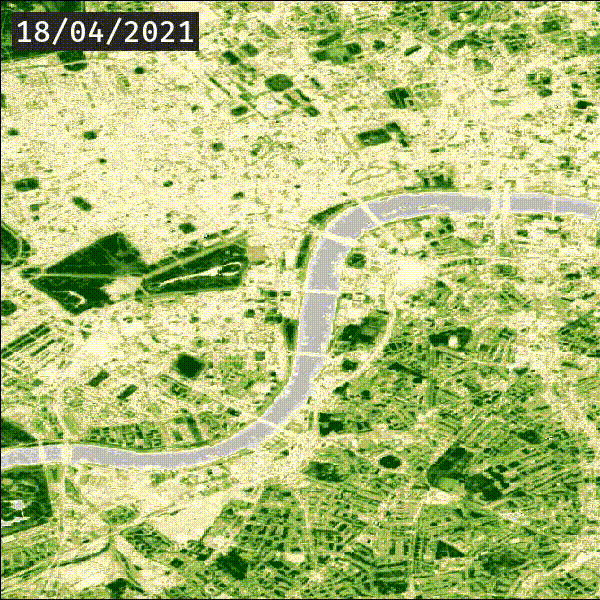

In [ ]:
from IPython.display import Image
Image(open('video.gif','rb').read())

... now imagine this over the whole year!

<big>**TASK 2: <font color="blue">Visualize your own false color composite**</font></big>

> False color images are a representation of a multi-spectral image produced using bands other than visible red, green and blue as the red, green and blue components of an image display. False color composites allow us to visualize wavelengths that the human eye can not see (i.e. near-infrared).

Suggestions: NIR, Red, Green (see [here](https://crisp.nus.edu.sg/~research/tutorial/opt_int.htm)) instead of the typical RGB.


In [ ]:
# TASK2: Write your code here!




### Solution for **<font color="blue">TASK 2</font>**:

In [ ]:
!ls ./drive/MyDrive/*.tif

./drive/MyDrive/RaVAEn_DEMO_S2_20210418.tif
./drive/MyDrive/RaVAEn_DEMO_S2_20210531.tif
./drive/MyDrive/RaVAEn_DEMO_S2_20220227.tif
./drive/MyDrive/RaVAEn_DEMO_S2_20220317.tif
./drive/MyDrive/RaVAEn_DEMO_S2_20220416.tif


In [ ]:
import pylab as plt
import numpy as np
def show_img(data, colorbar=True, figsize=None, cmap=None):
  # data = np.clip(data/3000., 0, 1)
  if figsize is not None:
    plt.figure(figsize=figsize)
  if cmap is None:
    plt.imshow(data, cmap=plt.get_cmap('gray'))
  else:
    plt.imshow(data, cmap=plt.get_cmap(cmap))

  if colorbar: plt.colorbar()
  plt.show()

# For reminding:
BANDS_S2 = ["B1 – Coastal aerosol",
  "B2 – Blue",
  "B3 – Green",
  "B4 – Red",
  "B5 – Vegetation red edge",
  "B6 – Vegetation red edge",
  "B7 – Vegetation red edge",
  "B8 – NIR",
  "B8A – Narrow NIR",
  "B9 – Water vapour",
  "B10 – SWIR – Cirrus",
  "B11 – SWIR",
  "B12 – SWIR",
  "QA60 – cloud mask information"]

# More information about the bands -> https://en.wikipedia.org/wiki/Sentinel-2

(669, 669, 15)
(669, 669, 3)


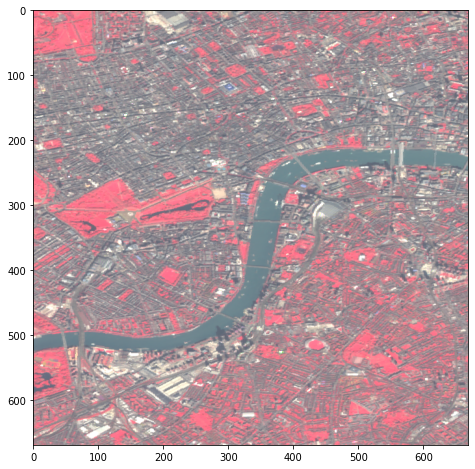

In [ ]:
s2_file = "./drive/MyDrive/RaVAEn_DEMO_S2_20220416.tif"

import rasterio
with rasterio.open(s2_file) as src:
  img = src.read()

img = np.moveaxis(img, 0, -1)

print(img.shape)

# select only your chosen bands
# composite = img[:,:,[3,2,1]] # 3=R, 2=G, 1=B
composite = img[:,:,[7,3,2]] # 7=NIR, 3=R, 2=G

composite = np.clip(composite/3500., 0, 1)

print(composite.shape)

show_img(composite, False, figsize=(8,8))